In [63]:
import numpy as np
import jax.numpy as jnp
import jax
import math

from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial
from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, taylor_expand_2d, matching_coeffs

from utils.distribution_utils import construct_pdf, construct_cdf

# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot, hist_with_errors


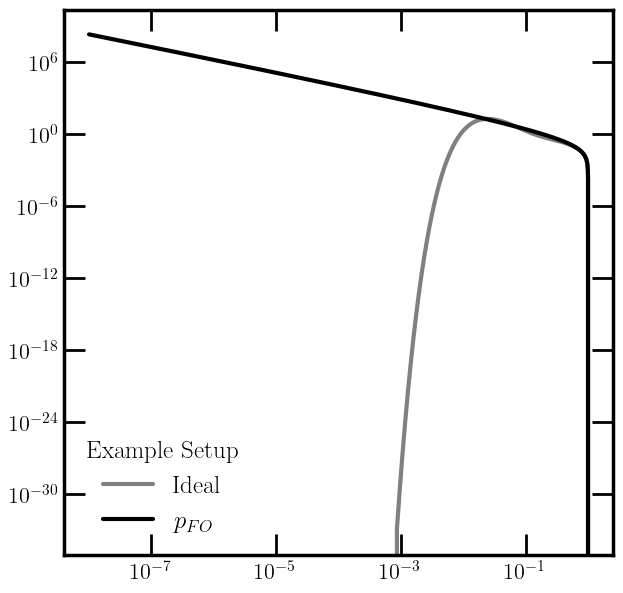

In [64]:

# Problem-dependent functions 
def t_from_x(x):
    return jnp.log(1/x)

def x_from_t(t):
    return jnp.exp(-t)


def p_ideal(t, alpha, params):
    alpha_bar = alpha #* 4/3 / jnp.pi
    return jnp.exp(-0.5 * alpha_bar * t**2 + 0.5 * alpha_bar**2 * t **4 - 0.5 * alpha_bar**3 * t**6) * (alpha_bar * t - 2 * alpha_bar**2 * t**3 + 3 * alpha_bar**3 * t**5)


# Taylor expansion of p(t| alpha) = exp(-alpha * t**2)(alpha * t)
def p_t(t, alpha, params):
    alpha_bar = alpha #* 4/3 / jnp.pi
    return alpha_bar * t #-  2.5 * alpha_bar**2 * t**3

p_x_ideal = lambda x, alpha, params: p_ideal(t_from_x(x), alpha, params) * jnp.abs(1/x)
p_x = lambda x, alpha, params: p_t(t_from_x(x), alpha, params) * jnp.abs(1/x)

def p_x(x, alpha, params):
    return p_t(t_from_x(x), alpha, params) * jnp.abs(1/x)


# Plot
xs = jnp.logspace(-8, 0, 10000)

fig, ax = newplot("full")
ax.plot(xs, p_x_ideal(xs, 0.118, None), label="Ideal", color = "grey")
ax.plot(xs, p_x(xs, 0.118, None), label=r"$p_{FO}$", color = "black")

ax.set_xscale("log")
ax.set_yscale("log")

plt.legend(title = "Example Setup")





In [65]:
def reduce_order(c_mn):

    M, N = c_mn.shape
    first_nonzero_m = 0
    for m in range(M):
        if np.any(c_mn[m, :] != 0):
            first_nonzero_m = m
            break

    first_nonzero_n = 0
    for n in range(N):
        if np.any(c_mn[:, n] != 0):
            first_nonzero_n = n
            break

    lowest_order_coeff = c_mn[first_nonzero_m, first_nonzero_n]

    return c_mn[first_nonzero_m:, first_nonzero_n:] / lowest_order_coeff, first_nonzero_m, first_nonzero_n, lowest_order_coeff


def log_match(c_mn, M, N):

    K = M + N

    polynomial_coeffs = polynomial_sum([polynomial_power(c_mn, k+1) / (k+1.0) for k in range(K+1)])
    return polynomial_coeffs[:M+1, :N+1]



In [66]:
M = 1
N = 1


def p_t(t, alpha, params):
    alpha_bar = alpha #* 4/3 / jnp.pi
    return alpha_bar * (1 - alpha_bar * t) 


# ########## Matching Algorithm ##########

def matching_coeffs(p_t, M, N):

    # There has to be *some* perturbative info!
    if M == 0:
        raise ValueError("M must be greater than 0")
 
    
    p_mn = taylor_expand_2d(p_t, 0.0, 0.0, M, N)
    P_mn = integrate_taylor_polynomial(p_mn)

    # print("p_mn")
    # print_polynomial(p_mn)
    # print("P_mn")
    # print_polynomial(P_mn)
    # print("")


    # Divide out the lowest order term of p_mn
    p_mn_reduced, m_star, n_star, p_star = reduce_order(p_mn)
    p_mn_reduced = p_mn_reduced.at[0, 0].set(0.0)

    p_matched = log_match(-p_mn_reduced, M, N)
    # p_matched = log_match(-p_mn_reduced, M - m_star, N-n_star)
    P_matched = log_match(P_mn, M, N) 

    # print("p_matched")
    # print_polynomial(p_matched)
    # print("P_matched")
    # print_polynomial(P_matched)
    # print("")


    g_mn = polynomial_sum([-p_matched, P_matched])
    g_star = jnp.zeros((M+1, N+1))
    g_star = g_star.at[m_star, n_star].set(-p_star)

    return g_mn, g_star


# g_mn_matched, g_star = matching_coeffs(exponential_distribution, 1, 1)
# print(g_mn_matched)
# print(g_star)


In [67]:
from utils.qcd_utils import running_coupling   
from jax.experimental.ode import odeint


mz = 91.1876

# def exponential_distribution(t, alpha, params):

#     scale = 91.1876 * x_from_t(t)
#     L = jnp.log(scale / mz)
#     alpha_bar = running_coupling(alpha, mz, scale)

#     alpha_bar = alpha_bar * 4/3 / jnp.pi

#     beta_0 = (11 * 3 - 2 * 5) / (12 * jnp.pi)

#     integral = jnp.log( 1 - 2 * alpha_bar * jnp.pi / 4 * 3 * beta_0 * L) / (2 * beta_0)


#     return alpha_bar * t * jnp.exp(-integral) 


# def p_order_N(t, alpha, M):

#     scale = 91.1876 * x_from_t(t)
#     alpha_bar = running_coupling(alpha, mz, scale)


#     result = 0
#     alpha_bar = alpha_bar * 4/3 / jnp.pi
#     for i in range(M + 1):
#         result += alpha_bar * t * jnp.power(-1 * alpha_bar * t **2 / 2, i) / math.factorial(i)
#     return result



def exponential_distribution(t, alpha, params):

    return alpha  * jnp.exp(-alpha * t)


def p_order_N(t, alpha, M):

    result = jnp.zeros_like(t)
    for i in range(M ):
        result += alpha * jnp.power(-1 * alpha * t , i) / math.factorial(i)
    return result



vmapped_polynomial = jax.vmap(polynomial, in_axes=(0, None, None))


def f(t, alpha, g_star, g_mn):


    poly = polynomial(t, alpha, g_mn)
    g_star_poly = polynomial(t, alpha, g_star)
    return -1 * g_star_poly * jnp.exp( - poly)


vmapped_f = jax.vmap(f, in_axes=(0, None, None, None))



# @jax.jit
# def integrate_f(t, alpha, g_star, g_mn):

#     # g_mn_alpha = collapse_in_alpha(alpha, g_mn)

#     # # Get the Gaussian (quadratic) part
#     # g0 = g_mn_alpha[0]
#     # g1 = g_mn_alpha[1]
#     # g2 = g_mn_alpha[2]

#     # prefactor = jnp.exp(-)

#     def dI_dt(I, t):
#         return f(t, alpha, g_star, g_mn)
    
#     I0 = 0.0
#     ts = jnp.array([0.0, t])
#     Is = odeint(dI_dt, I0, ts)

#     return Is[-1]



def integrate_f(t, alpha, g_star, g_mn):


    # Numerical integration
    ts = jnp.linspace(0, t, 1000)
    fs = vmapped_f(ts, alpha, g_star, g_mn)
    return jnp.trapz(fs, ts)


vmapped_integrate_f = jax.vmap(integrate_f, in_axes=(0, None, None, None))

@jax.jit
def q(t, alpha, g_star, g_mn):

    return vmapped_f(t, alpha, g_star, g_mn) * jnp.exp( -  vmapped_integrate_f(t, alpha, g_star, g_mn))


t = jnp.linspace(0, 10, 1000)



max_order = 5
num_trials = 50
colors = []



data = np.zeros((max_order, t.shape[0], num_trials))

for order in range(1, max_order):


    m_order = order
    n_order = 1 * order

    factorials = np.zeros((m_order + 2, n_order + 2))
    for i in range(factorials.shape[0]):
        for j in range(factorials.shape[1]):
            factorials[i, j] = (i+1) # math.factorial(i) #* math.factorial(j)




    print("Order: ", order)
    g_mn_matched, g_star = matching_coeffs(exponential_distribution, m_order, n_order)

    print("g_mn_matched")
    print_polynomial(g_mn_matched)


    for trial in range(num_trials):

        seed = jax.random.PRNGKey(trial * 1000 + order * 100) 

        # print(g_mn_matched)
        # print(g_star)
    
        
        std = 10 / factorials
        g_mn = (2 * (jax.random.uniform(seed, factorials.shape))-1)   * std# - (std / 2)
        max_m = g_mn.shape[0]
        max_n = g_mn.shape[1]
        # print(max_m, max_n)


        # set the highest order term to be negative
        g_mn = g_mn.at[order+1:max_m, max_n-1].set(-jnp.abs(g_mn[order+1:max_m, max_n-1]))


        g_mn = g_mn.at[:m_order+1, :].set(0)
        g_mn = g_mn.at[:m_order+1, :n_order+1].set(g_mn_matched)
        # g_mn = g_mn.at[m_order+1:, :n_order+1].set(0.0)

        print("g_mn")
        print_polynomial(g_mn)
        


        data[order, :, trial] = jnp.nan_to_num(q(t, 0.118, g_star, g_mn))



Order:  1
g_mn_matched
c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 
c_1,0 = 0.00e+00 c_1,1 = 1.00e+00 
g_mn
c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 
c_1,0 = 0.00e+00 c_1,1 = 1.00e+00 c_1,2 = 0.00e+00 
c_2,0 = 8.99e-01 c_2,1 = 2.19e+00 c_2,2 = -9.80e-01 


/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:164: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)


g_mn
c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 
c_1,0 = 0.00e+00 c_1,1 = 1.00e+00 c_1,2 = 0.00e+00 
c_2,0 = -2.25e-01 c_2,1 = 8.38e-01 c_2,2 = -2.63e+00 
g_mn
c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 
c_1,0 = 0.00e+00 c_1,1 = 1.00e+00 c_1,2 = 0.00e+00 
c_2,0 = -2.87e+00 c_2,1 = -7.79e-01 c_2,2 = -2.19e-01 
g_mn
c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 
c_1,0 = 0.00e+00 c_1,1 = 1.00e+00 c_1,2 = 0.00e+00 
c_2,0 = 1.89e+00 c_2,1 = 2.32e+00 c_2,2 = -2.80e+00 
g_mn
c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 
c_1,0 = 0.00e+00 c_1,1 = 1.00e+00 c_1,2 = 0.00e+00 
c_2,0 = 3.09e-01 c_2,1 = -1.00e+00 c_2,2 = -1.06e+00 
g_mn
c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 
c_1,0 = 0.00e+00 c_1,1 = 1.00e+00 c_1,2 = 0.00e+00 
c_2,0 = 2.60e+00 c_2,1 = -1.39e+00 c_2,2 = -3.27e+00 
g_mn
c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 
c_1,0 = 0.00e+00 c_1,1 = 1.00e+00 c_1,2 = 0.00e+00 
c_2,0 = 2.38e+00 c_2,1 = -2.42e-01 c_2,2 = -2.54e+00 
g_mn
c_0,0 = 0.00e+00 

Order 1
0.58477163
0.94315594
0.55768883
0.93644595
0.68618774
0.99791837
0.9436431
0.9868516
0.99325573
0.8999997
0.7421031
0.89208055
0.7894367
0.683506
0.86621094
0.94595826
0.768081
0.7584828
0.7639204
0.6204615
0.6147357
0.73320097
0.89854586
0.6296445
0.6375891
0.45485014
0.99099785
0.6349011
0.6780351
0.4701401
0.9814422
0.7797319
0.8041284
0.90490675
0.8787974
0.78541416
0.87876976
0.52548665
0.7188921
0.69511616
0.7214803
0.7206839
0.98933506
0.8098748
0.95373225
0.4689704
0.843212
0.9750607
0.67183656
0.97604036
Order 2
0.80177236
0.9921418
0.99807197
0.92809415
0.8175746
0.9706444
0.8895096
0.94680715
0.82380676
0.89489424
0.9994687
0.9999603
0.880944
0.95871264
0.99825954
0.99917865
0.99933857
0.9851396
0.999989
0.86337113
0.8465681
0.9993429
0.9995519
0.95778006
0.999263
0.9212899
0.9112469
0.99947155
0.90503514
0.96087384
0.98660314
0.9609854
0.9993939
0.9649846
0.89923686
0.77309513
0.9910251
0.9999612
0.9996427
0.9992839
0.9644877
0.97476125
0.96691513
0.934847
0.985418

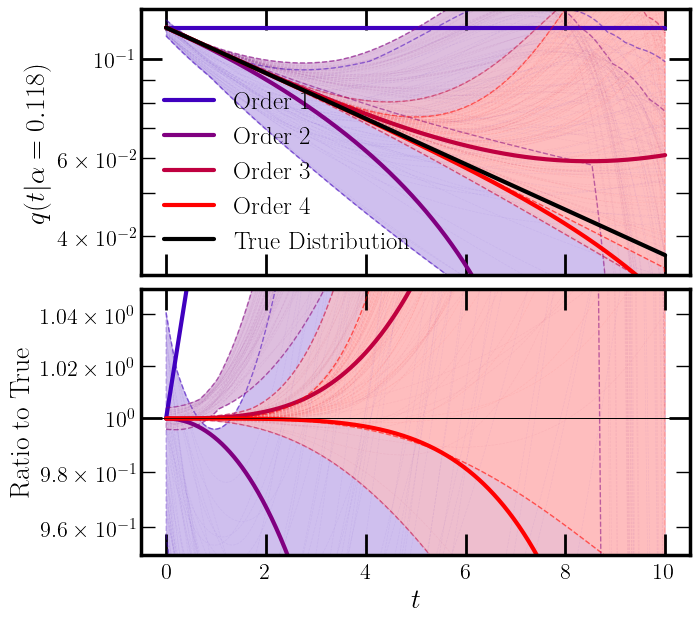

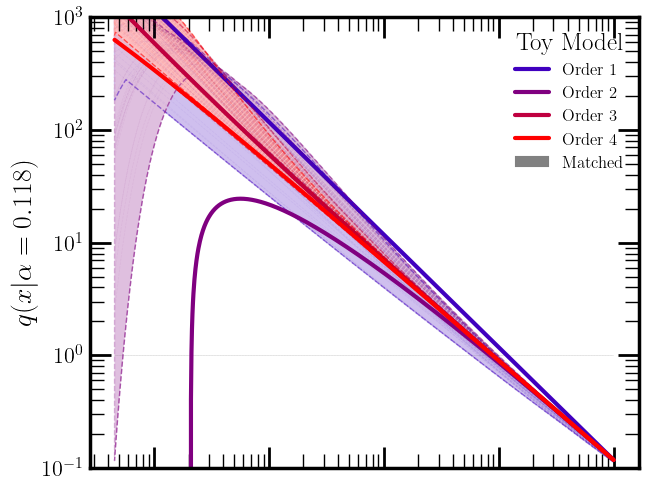

In [68]:
fig, ax = newplot("full", subplot_array=(2, 1), sharex=True)

colors = [0]


for order in range(1,max_order):

    o = (order) / (max_order-1)
    colors.append((o, 0, 1 - o))


for order in range(1, max_order):
    ax[0].plot(t, p_order_N(t, 0.118, order), label=f"Order {order}", color = colors[order],)



    for trial in range(num_trials):

        ax[0].plot(t, data[order, :,trial], color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)
        ax[1].plot(t, data[order, :,trial] / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)



    mean = np.nanmean(data[order], axis = 1)
    # std = np.nanstd(data[order], axis = 1)
    plus = np.nanmax(data[order], axis = 1)
    minus = np.nanmin(data[order], axis = 1)

    # plt.plot(t, mean, color = colors[order], linestyle = "--", label = f"Order {order} Mean")
    ax[0].plot(t, minus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].plot(t, plus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].fill_between(t, minus, plus, color = "white", alpha = 0.99, ls = "--")
    ax[0].fill_between(t, minus, plus, color = colors[order], alpha = 0.25, ls = "--")
    # ax[0].plot(t, mean, color = colors[order], linestyle = "--")
    

    # ax[1].plot(t, mean / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--")
    ax[1].plot(t, (minus) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].plot(t, (plus) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].fill_between(t, (minus) / exponential_distribution(t, 0.118, None), (plus) / exponential_distribution(t, 0.118, None), color = "white", alpha = 0.99, ls = "--")
    ax[1].fill_between(t, (minus) / exponential_distribution(t, 0.118, None), (plus) / exponential_distribution(t, 0.118, None), color = colors[order], alpha = 0.25, ls = "--")
    

    ax[1].plot(t, p_order_N(t, 0.118, order) / exponential_distribution(t, 0.118, None), color = colors[order],)
    ax[1].axhline(1, color = "black", linestyle = "-", lw = 0.5)

ax[0].plot(t, exponential_distribution(t, 0.118, None), label="True Distribution", color = "Black")


ax[0].legend(loc = "lower left")

ax[0].set_yscale("log")
ax[1].set_yscale("log")

ax[1].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$q(t|\alpha = 0.118)$")
ax[1].set_ylabel("Ratio to True")

# Decrease margin between subplots
plt.subplots_adjust(hspace = 0.05)

max_y = 1.1 * np.max(exponential_distribution(t[1:], 0.118, None))
min_y = 0.9 * np.min(exponential_distribution(t[1:], 0.118, None))
ax[0].set_ylim(min_y, max_y)
ax[1].set_ylim(0.95, 1.05)






# ######################### X version #########################

fig, ax = newplot("full", subplot_array=(2, 1), sharex=True)

xs = x_from_t(t)


# set ax[0] to take up the whole space

for order in range(1, max_order):

    print("Order" , order)

    ax[0].plot(xs, p_order_N(t, 0.118, order) / xs, label=f"Order {order}", color = colors[order],)



    for trial in range(num_trials):

        ax[0].plot(xs, data[order, :,trial] / xs , color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)
        ax[1].plot(xs, data[order, :,trial] / exponential_distribution(t, 0.118, None) , color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)

        integral = jnp.trapz(data[order, :,trial], t)
        # print(data[order, :,trial])
        print(integral)



    mean = np.nanmean(data[order], axis = 1) / xs
    plus = np.nanmax(data[order], axis = 1) / xs
    minus = np.nanmin(data[order], axis = 1) / xs


    std = np.nanstd(data[order], axis = 1) / xs

    # plt.plot(t, mean, color = colors[order], linestyle = "--", label = f"Order {order} Mean")
    ax[0].plot(xs, plus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].plot(xs, minus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].fill_between(xs, minus, plus, color = "white", alpha = 0.99, ls = "--")
    ax[0].fill_between(xs, minus, plus, color = colors[order], alpha = 0.25, ls = "--")
    # ax[0].plot(t, mean, color = colors[order], linestyle = "--")
    

    # ax[1].plot(t, mean / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--")
    ax[1].plot(xs, (minus) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].plot(xs, (plus) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].fill_between(xs, (minus) / exponential_distribution(t, 0.118, None) * xs, (plus) / exponential_distribution(t, 0.118, None)* xs, color = "white", alpha = 0.99, ls = "--")
    ax[1].fill_between(xs, (minus) / exponential_distribution(t, 0.118, None)* xs, (plus) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], alpha = 0.25, ls = "--")


    ax[1].plot(xs, p_order_N(t, 0.118, order) / exponential_distribution(t, 0.118, None), color = colors[order],)
    ax[1].axhline(1, color = "black", linestyle = "-", lw = 0.5)

# ax[0].plot(xs, exponential_distribution(t, 0.118, None)/ xs, label="True", color = "Black")

# Add shaded to legend
ax[0].fill_between(xs, np.ones_like(xs), np.ones_like(xs), color = "grey", alpha = 0.99, ls = "--", label = "Matched", lw = 0.1)


ax[0].legend(loc = "upper right", fontsize = 12, title = "Toy Model")

ax[0].set_yscale("log")
# ax[1].set_yscale("log")
ax[0].set_xscale("log")

ax[1].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$q(x|\alpha = 0.118)$")
ax[1].set_ylabel("Ratio to True")

# Decrease margin between subplots
plt.subplots_adjust(hspace = 0.05)

ax[0].set_ylim(1e-1, 1e3)
ax[1].set_ylim(1/1.1, 1.1)

fig.delaxes(ax[1])
# set ax[0] height 
fig.set_figheight(12)

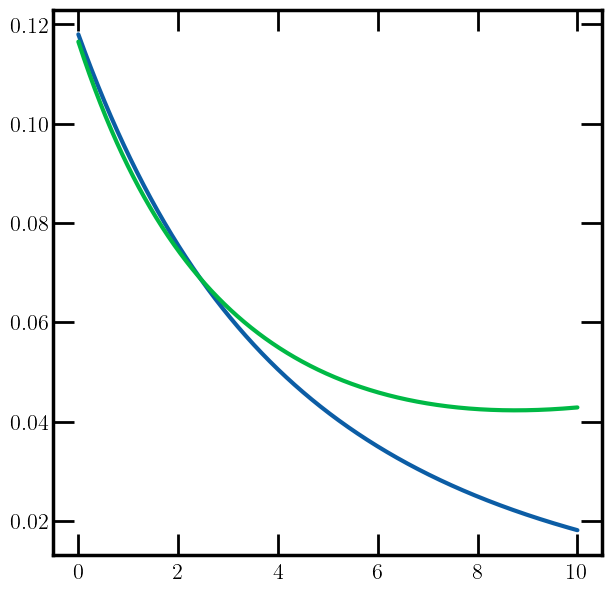

In [69]:
def test(t, alpha):
    return alpha * jnp.exp(-alpha * t - 1 + jnp.exp(- alpha * t))


fig, ax = newplot("full")
ax.plot(t, test(t, 0.118))
ax.plot(t, data[1,:,0])

# Parameter Extraction

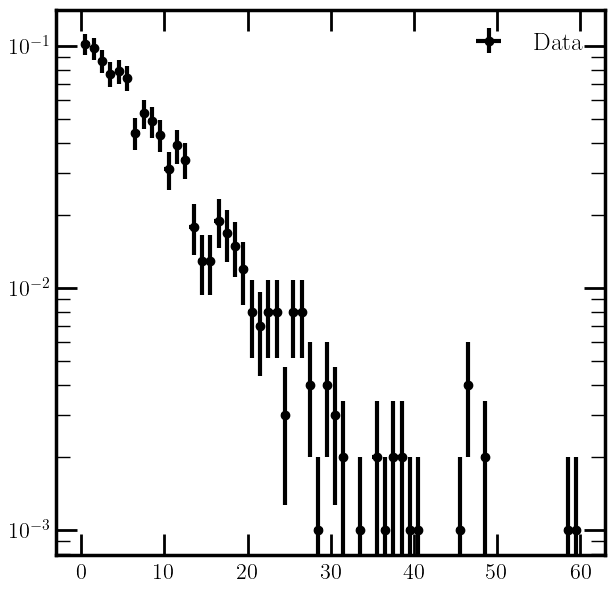

In [70]:
N_data = 1000
alpha_true = 0.118

# Sample an exponential distribution
seed = jax.random.PRNGKey(0)
t_data = jax.random.exponential(seed, (N_data,)) / alpha_true

fig, ax = newplot("full")
bins = 100
hist_with_errors(ax, t_data, bins = bins, range = [0, 100], label = "Data", color = "black", weights=np.ones_like(t_data)/N_data)
counts, bins = np.histogram(t_data, bins = 100, range = [0, 100], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2

plt.legend()

plt.yscale("log")

Text(0, 0.5, '$-2 \\log L(\\alpha)$')

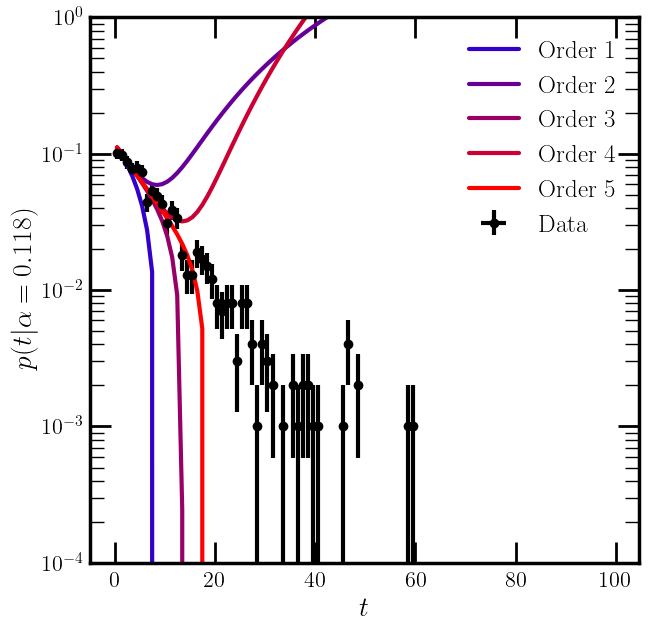

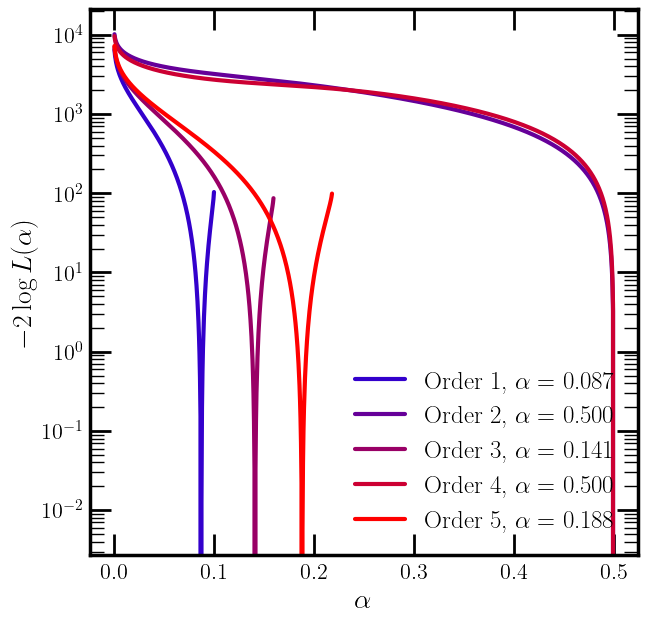

In [71]:
# Get lambda functions for FO likelihoods

def p_order_N(t, alpha, M):

    result = 0
    for i in range(M + 1):
        result += alpha  * jnp.power(-1 * alpha * t, i) / math.factorial(i)
    return result




max_M = 5


fig, ax = newplot("full")
bins = 100
hist_with_errors(ax, t_data, bins = bins, range = [0, 100], label = "Data", color = "black", weights=np.ones_like(t_data)/N_data)
counts, bins = np.histogram(t_data, bins = 100, range = [0, 100], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2

for i in range(1, max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)

    res = (lambda x : p_order_N(bin_centers, x, i))(0.118)
    ax.plot(bin_centers, res, label = f"Order {i}", color = color)
plt.yscale("log")

plt.xlabel(r"$t$")
plt.ylabel(r"$p(t|\alpha = 0.118)$")

plt.ylim(1e-4, 1e0)

plt.legend()


fig, ax = newplot("full")                                                                       
for i in range(1, max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)


    vmapped_p_order_N = jax.vmap(p_order_N, in_axes=(0, None, None))
    t_sorted = jnp.sort(t_data)
    t_sorted = t_sorted[t_sorted < 10]


    def likelihood_function(alpha):

        likelihoods = -2 * jnp.log(vmapped_p_order_N(t_sorted, alpha, i))
        cumulative_sum = jnp.cumsum(likelihoods)

        # return jnp.nanmin(cumulative_sum)
        return cumulative_sum[-1]
    


    vmapped_likelihood_function = jax.vmap(likelihood_function)
    alphas = jnp.linspace(0.00, 0.5, 1000)
    likelihoods = vmapped_likelihood_function(alphas)

    best_alpha = alphas[jnp.nanargmin(likelihoods, axis = 0)]  
    best_likelihood = likelihood_function(best_alpha)

    likelihoods = likelihoods - best_likelihood



    # best_alpha = alphas[jnp.argmin(likelihoods, axis = 0)]
    # ax.plot(t_sorted, best_alpha, label = f"Order {i}")
    
    ax.plot(alphas, likelihoods, label = f"Order {i}, " + r"$\alpha = $" +  f"{best_alpha : .3f}", color = color)

plt.legend()
plt.yscale("log")

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$-2 \log L(\alpha)$")


/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:164: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)


KeyboardInterrupt: 

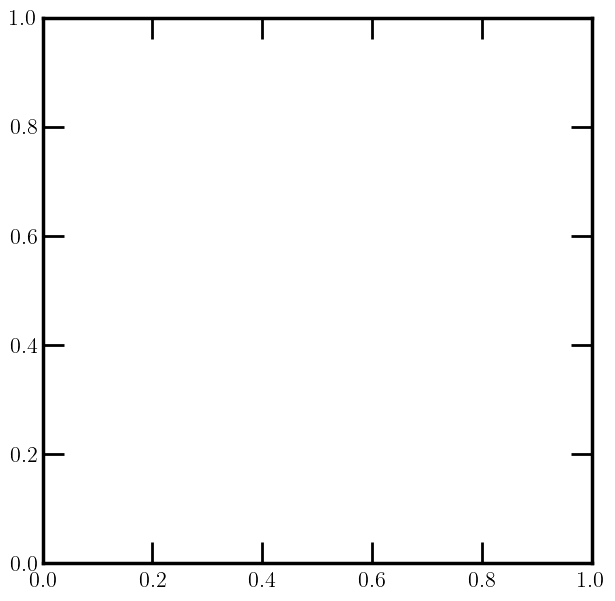

In [ ]:
from scipy.optimize import minimize
from tqdm import tqdm


num_higher_orders = 3

max_M = 5

fig, ax = newplot("full")                                                                       
for i in range(1,max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)

    
    g_mn_matched, g_star = matching_coeffs(exponential_distribution, i, i)
    g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
    # print(g_mn_matched.shape)
    # print(g_mn.shape)
    # print(i+1, i)

    g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)

    # We can only change parameters after the matched order in alpha
    non_frozen_params_mask = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders), dtype = bool)
    non_frozen_params_mask = non_frozen_params_mask.at[i+1:, :].set(True)


    @jax.jit
    def likelihood_function(params):

        alpha = params[0]
        g_mn_higher = params[1:]

        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))

        # print("")
        # print(g_mn_matched.shape)
        # print(g_mn.shape)
        # print(g_mn_higher.shape)

        g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)

        return -2 * jnp.sum(jnp.log(q(t_data, alpha, g_star, g_mn)))
    
    @jax.jit
    def profile_likelihood_function(g_mn_higher, alpha):

        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
        g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)

        return -2 * jnp.sum(jnp.log(q(t_data, alpha, g_star, g_mn)))
    

    # Minimize likelihood function
    initial_alpha = 0.118
    initial_guess = jnp.zeros(g_mn.shape[1]+1)

    initial_guess = initial_guess.at[0].set(initial_alpha)


    res_full = minimize(likelihood_function, initial_guess, method='Nelder-Mead', options={'disp': False})

    alphas = jnp.linspace(0.11, 0.13, 50)

    def profile_minimize(alphas):
        res_partial = minimize(profile_likelihood_function, res_full.x[1:], args=(alphas), method='Nelder-Mead', options={'disp': False})
        return res_partial.fun

    likelihoods = jnp.zeros(alphas.shape)
    for j, alpha in tqdm(enumerate(alphas)):
        res_partial = profile_minimize(alpha)
        likelihoods = likelihoods.at[j].set(res_partial)

    likelihoods = likelihoods - res_full.fun

    ax.plot(alphas, likelihoods, label = f"Order {i}", color = colors[i])

    # Get the alphas where the likelihood is within 1 of the minimum
    min_alpha = alphas[jnp.argmin(likelihoods[:-1])]
    ax.axvline(min_alpha, linestyle = "--", lw = 0.5, color = colors[i])

    where_less_than_one = jnp.where(likelihoods < 1)
    alphas_less_than_one = alphas[where_less_than_one]



    # minus_one = alphas_less_than_one[0]
    # plus_one = alphas_less_than_one[-2]

    # Vertical band
    # ax.axvspan(minus_one, plus_one, alpha=0.1, color=colors[i])

    print("Order", i)
    print("Min Alpha", min_alpha)
    # print("Range", minus_one, plus_one)

    
    # vmapped_likelihood_function = jax.vmap(likelihood_function)
    # alphas = jnp.linspace(0.00, 1.0, 100)
    # likelihoods = vmapped_likelihood_function(alphas)
    

    # min_alpha = alphas[jnp.argmin(likelihoods)]

    # ax.plot(alphas, likelihoods, label = f"Order {i}", color = f"C{i}")
    # ax.axvline(min_alpha, linestyle = "--", lw = 0.5, color = f"C{i}")

ax.axvline(0.118, linestyle = "--", lw = 0.5, color = "black")

plt.yscale("log")

<function jax._src.scipy.optimize.minimize.minimize(fun: Callable, x0: jax.Array, args: Tuple = (), *, method: str, tol: Union[float, NoneType] = None, options: Union[Mapping[str, Any], NoneType] = None) -> jax._src.scipy.optimize.minimize.OptimizeResults>